In [85]:
import numba
import time
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

lendo conj. dados

In [86]:
data = pd.read_csv('dataset\\sleeptime_prediction_dataset.csv')
data.head(3)

,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
0,1.12,0.52,3.29,7.89,216.08,0.75,3.45
1,2.85,0.49,4.22,5.03,206.18,0.67,4.88
2,2.20,1.81,4.04,9.23,28.73,0.35,3.61


In [87]:
data.shape

(2000, 7)

## Previsão de tempo de sono
1) Ajuste um modelo linear da forma
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \ldots + a_m x_m,
$$
onde $y$ é o tempo de sono e $x_i$ são as variáveis independentes (colunas do dataset).

Resposta:

$b$=É o valor previsto

$y$=É o valor real

$a$ = $[a_0, a_1, ...., a_n]$ ,É o vetor dos coeficientes do modelo incluindo o interceptor

$M$ = Matriz das carateristicas(features), no qual adciona a coluna do intercepto($a_0$)

$$
b = M\cdot a 
$$

In [88]:
# Matriz de caracteristicas/Independente
X = data.drop(columns=['SleepTime']).values.astype(np.float32)

# Matriz do valor real
y = data['SleepTime'].values.astype(np.float32).reshape(-1, 1)

In [89]:
M = np.concatenate((np.ones((X.shape[0],1), dtype=np.float32), X), axis=1)

In [90]:
M[0, :]

array([  1.  ,   1.12,   0.52,   3.29,   7.89, 216.08,   0.75],
      dtype=float32)

> Primeira coluna é do inteceptor

In [91]:
b = y

2) Escreva o sistema linear $M a = b$ associado aos mínimos quadrados que representa o modelo ajustado (lembre-se que as variáveis do problema de ajuste são os coeficientes $a_i$ e os dados são os valores de $x_i$ e $y$).


* O objetivo é encontrar $\alpha$ que minimiza o erro onde:
$$
E = ||b - M\cdot a||^2 =  (b - Ma)^T (b-Ma) = b^Tb - 2a^TX^Ty + a^T M^T Ma$$

* Deriva em relação a $a$:
$$
\frac{∂E}{∂a} = -2M^Tb + 2M^TMa = 0
$$

* Resolve 
$$M^TMa =M^Tb $$

Observação: $A=M^TM$ o $b = M^Tb$

**Usando decomposição QR:**

1. $X^T X b = X^T y$
2. $(QR)^T (QR) b = (QR)^T y$
3. $R^T (Q^T Q) R b = R^T Q^T y$
4. $R^T R b = R^T Q^T y$
5. $(R^T)^{-1} R^T R b = (R^T)^{-1} R^T Q^T y$
5. $R b = Q^T y$
   * $\alpha = Q^T y$ 
6.  $R b = \alpha$

In [92]:
def decomposicaoQR(A):
    row, col = A.shape
    if col > row: return 0
    
    # Inicializando as matrizes Q e R
    Q = np.zeros(shape=(row, col), dtype=np.float32)
    R = np.zeros(shape=(col, col), dtype=np.float32)
    u = 0
    for i in range(col):
        u = A[:, i]
        for j in range(i):
            R[j, i] = np.dot(Q[:, j], A[:, i])
            u -= np.multiply(R[j, i] , Q[:, j])

        R[i, i] = np.linalg.norm(u).astype(np.float32)
        if R[i, i] == 0: return 0
        Q[:, i] = np.divide(u , R[i, i]).astype(np.float32)
    return Q, R

def regressaoQR(M, b):
    M_ = M.copy()
    Q, R = decomposicaoQR(M_)

    alpha = np.dot(Q.T, b)

    norm_ = np.linalg.norm(np.dot(Q,Q.T) - np.eye(Q.shape[0]), "fro")
    print("Norm fro : ", norm_)
    return np.linalg.solve(R, alpha)

**Usando decomposição LU:**
1. $M^T M a = M^T b$
2. $A a = M^T b$
3. $LU a = M^T b$
4. $L z = M^T b$
5. $U a = z$

In [93]:
def decomposicaoLU(M):
    A = np.dot(M.T, M)
    L = np.diag(np.ones(A.shape[1]))
    U = np.copy(L)

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if i<=j:
                U[i, j] = A[i, j] - np.sum(L[i, :j] * U[:j, j])
            if i >j:
                L[i, j] =  (A[i, j] - np.sum(L[i, :i] * U[:i, j])) / U[j, j]
    return L, U

def regressaoLU(M, b):
    L, U = decomposicaoLU(M)
    y = np.dot(M.T, b)
    x = np.linalg.solve(L, y)
    x = np.linalg.solve(U, x)
    return x

Função de predição

In [94]:
# função retorna o valor predito pelo modelo
def predict(x, coef):
    return np.ravel(np.dot(x, coef))

3) Separe seus dados em 80% para treinamento e 20% para teste. Resolva o sistema linear utilizando dois métodos de sua escolha e apenas os dados de treinamento.

In [95]:
# Essa função divide dados de train e test
def train_test(X , y, trainSize=0.80, randomState=42):
    N, _ = X.shape
    # Indeces
    index = np.arange(0, N)

    # definindo o tamanho de instancias do dados de train
    sizeTrain = int(N*trainSize)
    print(sizeTrain)

    # Seleciona indices aleatorios 
    trainIndex = np.random.RandomState(randomState).choice(index, size=sizeTrain, replace=False)

    # Pega as instancias de treinamento
    train = ( X[trainIndex, :],  y[trainIndex, :] )

    # Pega os indices de teste
    testIndex = list(set(index.tolist()) - set(trainIndex.tolist()))
    
    

    #  ====> Verifica os valores que não estão contido em ambos array
    test = ( X[testIndex, :], y[testIndex, :] )

    # Retorna os dados de treinamento e teste
    return train[0], train[1], test[0], test[1] 

In [96]:
set(np.array([12,32, 12 ,32 ]).tolist())

{12, 32}

In [97]:
xtrain, ytrain, xtest, ytest = train_test(M, b, trainSize=0.8, randomState=1)

1600


In [98]:
M.shape, xtrain.shape, xtest.shape

((2000, 7), (1600, 7), (400, 7))

In [99]:
tempo_execucao = {
    'QR': 0,
    'LU': 0,
    'QR_Poly': 0,
    'LU_Poly': 0
}

In [100]:
# Parametros do modelo QR
start_ = time.time() # Inicia o cronometro
coefQR = regressaoQR(xtrain, ytrain)
end_ = time.time()   # Para o cronometro
tempo_execucao['QR'] = end_ - start_


# Parametros do modelo LU
start_ = time.time()
coefLU = regressaoLU(xtrain, ytrain)
end_ = time.time()

tempo_execucao['LU'] = end_ - start_

Norm fro :  39.91240408687964


4. Calcule o erro resíduo no conjunto de treinamento e no conjunto de teste.

In [101]:
trainResidualQR = ytrain - predict(xtrain, coefQR).reshape(-1, 1)

trainResidualLU = ytrain - predict(xtrain, coefLU).reshape(-1, 1)

In [102]:
testResidualQR = ytest - predict(xtest, coefQR).reshape(-1, 1)

testResidualLU = ytest - predict(xtest, coefLU).reshape(-1, 1)

5) Compare os resultados dos dois métodos.

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [104]:
def metricas(pred, true, method=''):
    print("Metricas para o método ", method)
    print("RMSE...: ", mean_squared_error(true, pred))
    print("MAE....: ", mean_absolute_error(true, pred))
    print("R2.....: ", r2_score(true, pred))

In [105]:
metricas(predict(xtrain, coefQR), ytrain, 'QR')

Metricas para o método  QR
RMSE...:  3.1601202
MAE....:  0.5925603
R2.....:  0.24654191732406616


In [106]:
metricas(predict(xtrain, coefLU), ytrain, 'LU')

Metricas para o método  LU
RMSE...:  3.160119925602487
MAE....:  0.5925617062897593
R2.....:  0.2465419888471131


6) Faça um histograma dos resíduos no conjunto de treinamento e no conjunto de teste.

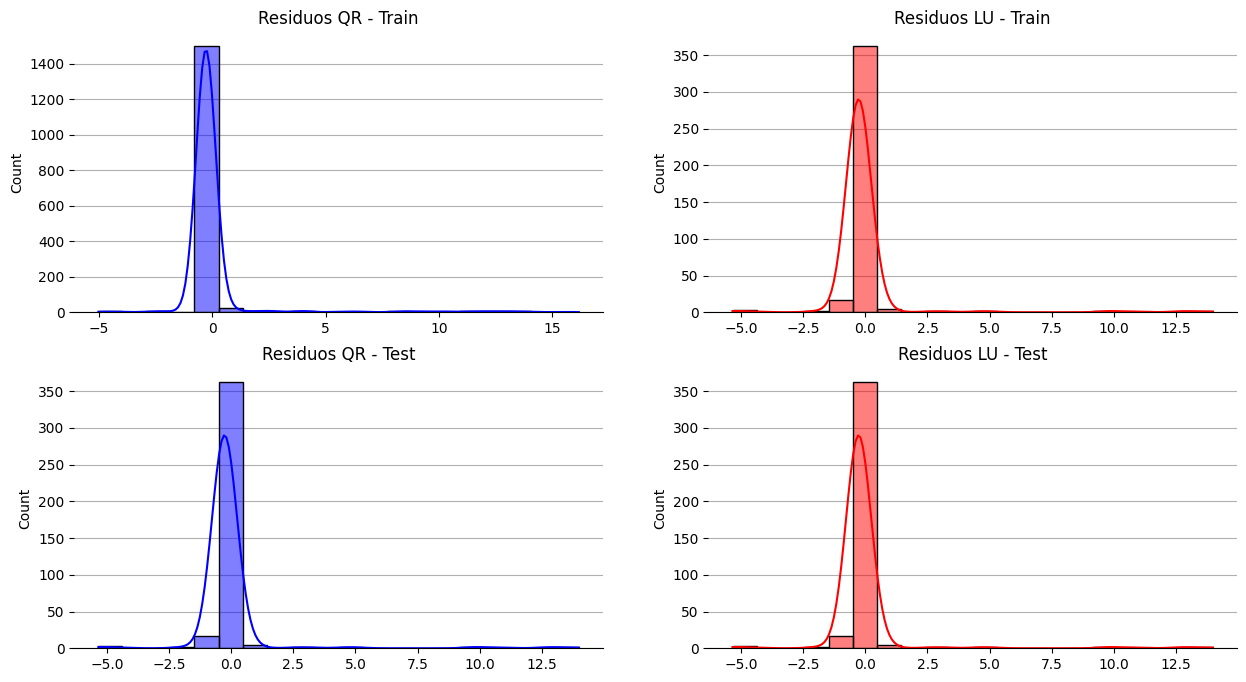

In [107]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))


# Residuos QR
sea.histplot(trainResidualQR.reshape(1, -1)[0], bins=20, color='blue', ax=ax[0, 0], kde=True)
ax[0][0].set_title('Residuos QR - Train')
ax[0][0].spines[['right', 'top', 'left']].set_visible(False)
ax[0][0].grid(True, axis='y')
ax[0][0].set_axisbelow(True)



sea.histplot(testResidualLU.reshape(1, -1)[0], bins=20, color='red', ax=ax[0, 1], kde=True)
ax[0][1].set_title('Residuos LU - Train')
ax[0][1].spines[['right', 'top', 'left']].set_visible(False)
ax[0][1].grid(True, axis='y')
ax[0][1].set_axisbelow(True)


# Residuos LU
sea.histplot(testResidualLU.reshape(1, -1)[0], bins=20, color='red', ax=ax[1, 1], kde=True)
ax[1][1].set_title('Residuos LU - Test')
ax[1][1].grid(True, axis='y')
ax[1][1].set_axisbelow(True)
ax[1][1].spines[['right', 'top', 'left']].set_visible(False)

sea.histplot(testResidualQR.reshape(1, -1)[0], bins=20, color='blue', ax=ax[1, 0], kde=True)
ax[1][0].set_title('Residuos QR - Test')
ax[1][0].spines[['right', 'top', 'left']].set_visible(False)
ax[1][0].grid(True, axis='y')
ax[1][0].set_axisbelow(True)
plt.show()

In [108]:
from scipy.stats import anderson

# Verificando a normalidade dos residuos com o teste de Shapiro
for i in [trainResidualLU, trainResidualQR, testResidualLU, testResidualQR]:
    resultado = anderson(i.reshape(1, -1)[0])
    if resultado.statistic < resultado.critical_values[2]:  # 5% de significância
        print("Os dados parecem normais.")
    else:
        print("Os dados NÃO são normais.")

Os dados NÃO são normais.
Os dados NÃO são normais.
Os dados NÃO são normais.
Os dados NÃO são normais.


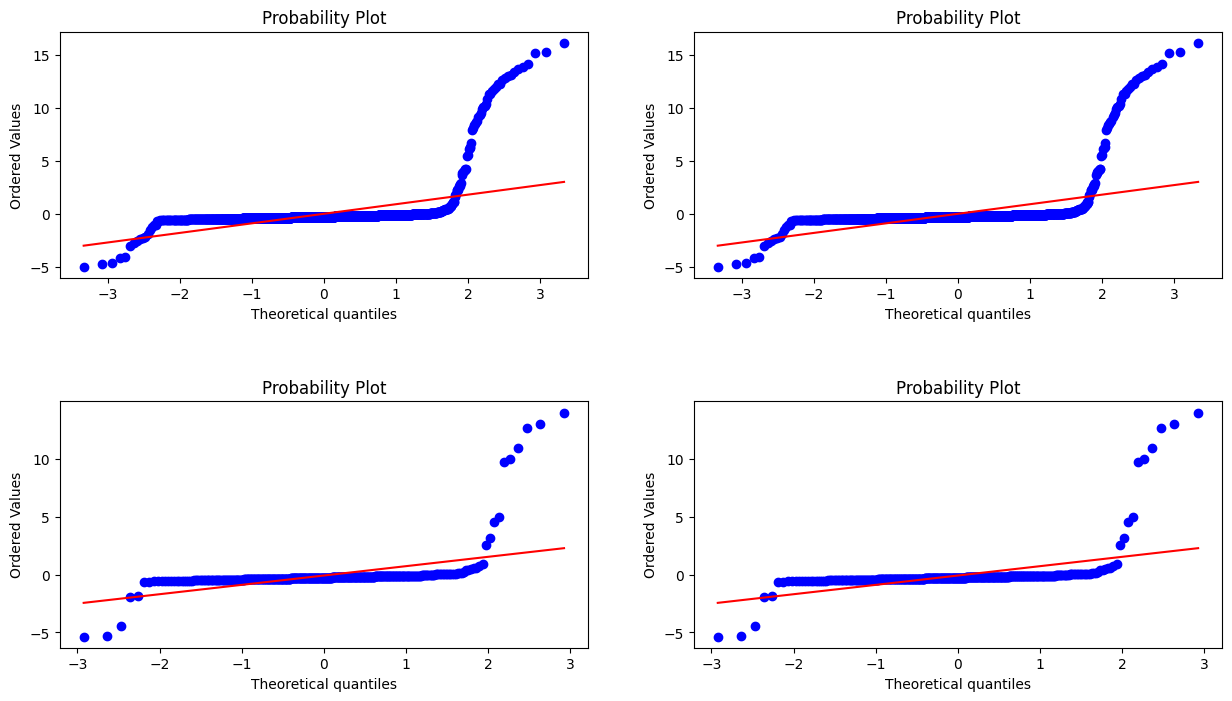

In [109]:
from scipy.stats import probplot # probplot verifica a normalidade

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5)

# Residuos QR
data = [trainResidualLU, trainResidualQR, testResidualLU, testResidualQR]

# Probplot para os residuos verificando a normalidade
for i, axis in zip(data, ax.flatten()): 
    probplot(i.reshape(1, -1)[0],dist='norm', plot=axis)

plt.show()

> Os residuos não seguem uma distribuição normal

7) Ajuste um modelo do tipo polinomial de grau 2 para prever o tempo de sono.

In [110]:
from sklearn.preprocessing import PolynomialFeatures

In [111]:
x = PolynomialFeatures(degree=4, include_bias=False).fit_transform(X)
x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)

In [112]:
xtrainP, ytrainP, xtestP, ytestP = train_test(x, b, trainSize=0.8, randomState=1)

1600


In [113]:
start_ = time.time()
coefQRPoly = regressaoQR(xtrainP, ytrainP)
end_   = time.time()

tempo_execucao['QR_Poly'] = end_ - start_


start_ = time.time()
coefLUPoly = regressaoLU(xtrainP, ytrainP)
end_   = time.time()

tempo_execucao['LU_Poly'] = end_ - start_

Norm fro :  37.28270377036469


8. Compare os resultados do modelo polinomial com o modelo linear.

In [114]:
pd.DataFrame(tempo_execucao, index=['Tempo de execução'])

,QR,LU,QR_Poly,LU_Poly
Tempo de execução,0.228476,0.002424,2.577997,1.257775


> O QR_Poly e LU_Poly foram mais lentos, isso é esperados já que estamos treinando mais caracteristicas

In [115]:
testResidualQRPoly = ytestP - predict(xtestP, coefQRPoly).reshape(-1, 1)

testResidualLUPoly = ytestP - predict(xtestP, coefLUPoly).reshape(-1, 1)

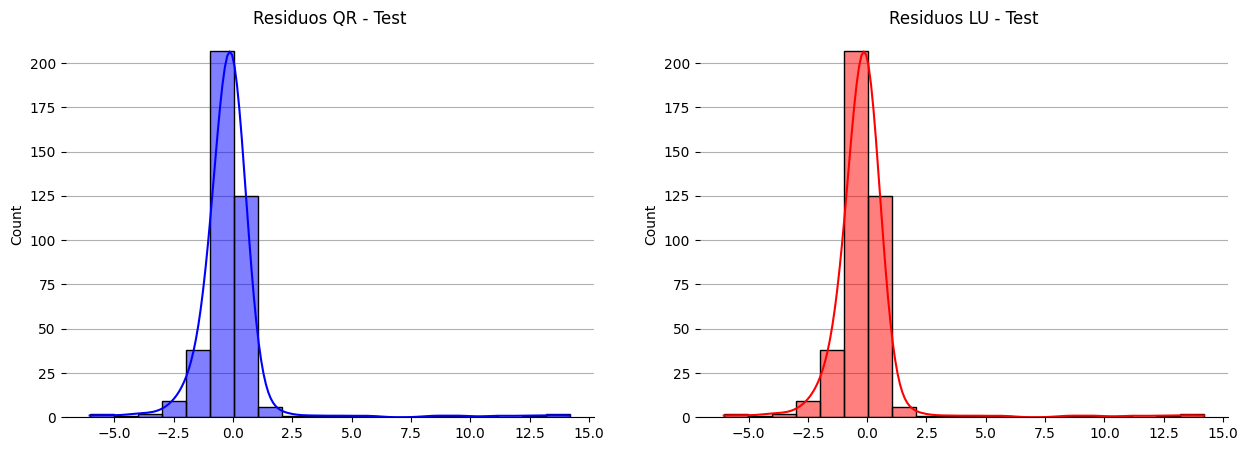

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


# Residuos QR
sea.histplot(testResidualQRPoly.reshape(1, -1)[0], bins=20, color='blue', ax=ax[0], kde=True)
ax[0].set_title('Residuos QR - Test')
ax[0].spines[['right', 'top', 'left']].set_visible(False)
ax[0].grid(True, axis='y')
ax[0].set_axisbelow(True)



sea.histplot(testResidualLUPoly.reshape(1, -1)[0], bins=20, color='red', ax=ax[1], kde=True)
ax[1].set_title('Residuos LU - Test')
ax[1].spines[['right', 'top', 'left']].set_visible(False)
ax[1].grid(True, axis='y')
ax[1].set_axisbelow(True)


plt.show()

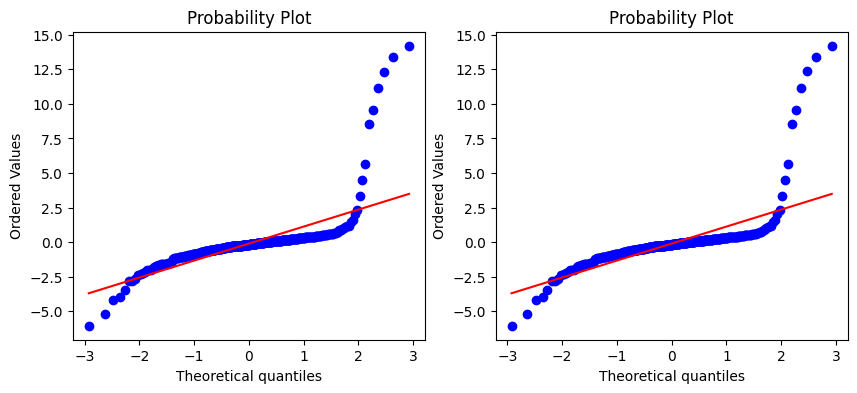

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

residuo = [testResidualQRPoly, testResidualLUPoly]

for i, axis in zip(residuo, ax.flatten()):
    probplot(i.reshape(1, -1)[0],dist='norm', plot=axis)

plt.show()

In [118]:
metricas(predict(xtestP, coefQRPoly), ytestP, 'LU Poly')

metricas(predict(xtest, coefLU), ytest, 'QR Poly')

Metricas para o método  LU Poly
RMSE...:  2.9798806043852943
MAE....:  0.7496826951662067
R2.....:  0.21227626786758813
Metricas para o método  QR Poly
RMSE...:  2.5666663327542962
MAE....:  0.5381338268594441
R2.....:  0.32150839204750703


In [119]:
metricas(predict(xtrainP, coefQRPoly), ytrainP, 'LU Poly')

metricas(predict(xtrain, coefLU), ytrain, 'QR Poly')

Metricas para o método  LU Poly
RMSE...:  2.7400045005366254
MAE....:  0.7118651682320134
R2.....:  0.3467088622813308
Metricas para o método  QR Poly
RMSE...:  3.160119925602487
MAE....:  0.5925617062897593
R2.....:  0.2465419888471131


> Tem resultados piores contudo ambos modelos são ruins, já que residuos não seguem uma normalidade

Test, Fazendo transformação logaritimica

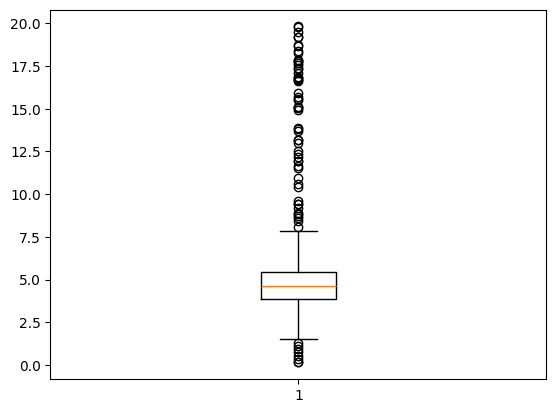

In [120]:
plt.boxplot(b)
plt.show()

> Isso é feito para quando há presença de outliers no conj. dados, vamos ver se há um melhor resultado fazendo esse método

In [121]:
xtrain, ytrain, xtest, ytest = train_test(M, np.log1p(b), trainSize=0.8, randomState=1)

1600


In [122]:
coefLU = regressaoLU(xtrain, ytrain)
coefQR = regressaoQR(xtrain, ytrain)

Norm fro :  39.91240408687964


In [123]:
testResidualLU = ytest - predict(xtest, coefLU)
testResidualQR = ytest - predict(xtest, coefQR)

In [124]:
metricas(predict(xtest, coefQR), ytest, 'QR')

metricas(predict(xtest, coefLU), ytest, 'LU')

Metricas para o método  QR
RMSE...:  0.03732249
MAE....:  0.05952925
R2.....:  0.47228819131851196
Metricas para o método  LU
RMSE...:  0.0373225065669818
MAE....:  0.05952947755829907
R2.....:  0.47228797369995257


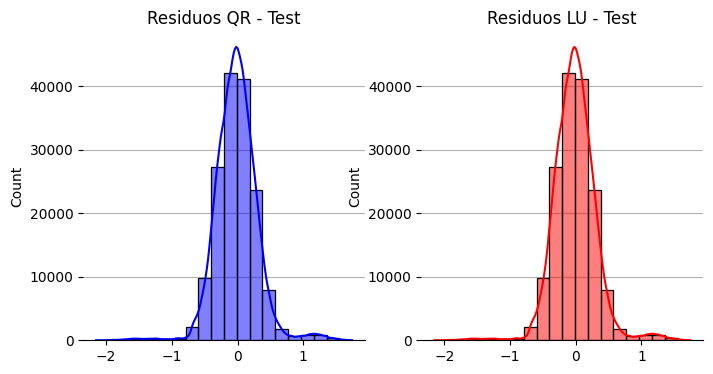

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Residuos QR
sea.histplot(testResidualQR.reshape(1, -1)[0], bins=20, color='blue', ax=ax[0], kde=True)
ax[0].set_title('Residuos QR - Test')
ax[0].spines[['right', 'top', 'left']].set_visible(False)
ax[0].grid(True, axis='y')
ax[0].set_axisbelow(True)


# Residuos LU   
sea.histplot(testResidualLU.reshape(1, -1)[0], bins=20, color='red', ax=ax[1], kde=True)
ax[1].set_title('Residuos LU - Test')
ax[1].spines[['right', 'top', 'left']].set_visible(False)
ax[1].grid(True, axis='y')
ax[1].set_axisbelow(True)
plt.show()

Os dados NÃO são normais. 952.71 0.787
Os dados NÃO são normais. 952.73 0.787


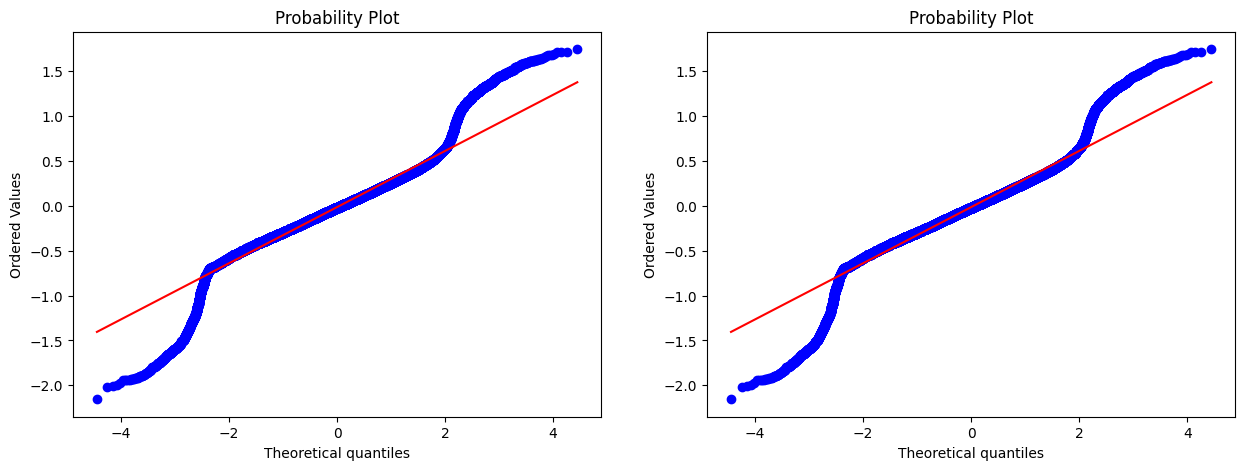

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
residual = [testResidualLU, testResidualQR]

for i, axis in zip(residual, ax.flatten()):
    resultado = anderson(i.reshape(1, -1)[0])
   
    if resultado.statistic < resultado.critical_values[2]:  # 5% de significância
        print("Os dados parecem normais.", round(resultado.statistic,2), resultado.critical_values[2])
    else:
        print("Os dados NÃO são normais.", round(resultado.statistic, 2), resultado.critical_values[2])
    
    probplot(i.reshape(1, -1)[0],dist='norm', plot=axis)
    

plt.show()

> Resultdos ruins

9. Faça 5 slides para apresentar o seu trabalho.